PCA is used widely in data science. It’s a way to reduce the number of dimensions in a data set. In a stock portfolio, a dimension might be a column of returns for one of the stocks. In a portfolio of 100 stocks, there are 100 dimensions. PCA converts those 100 dimensions into the few that explain the most variance in the data. In other words, the dimensions hold the most information about the data.

Quants use factors in trading strategies. First, they isolate the components. Then they buy the stocks with the largest exposure to a factor and sell the stocks with the smallest exposure to a factor.

In [31]:
import yfinance as yf

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [32]:
symbols = [
    'SQ',
    'AMZN',
    'IBM',
    'TSLA',
    'NFLX',
    'TSM',
    'MSFT',
    'META',
    'INTC',
    'NEM',
    'AU',
    'AEM',
    'GFI'
]
data = yf.download(symbols, start="2020-01-01", end="2022-11-30")
portfolio_returns = data['Adj Close'].pct_change().dropna()

[*********************100%***********************]  13 of 13 completed


# Fit a PCA model

In [33]:
# sklearn makes it easy to fit a PCA model and get the components.

pca = PCA(n_components=3)
pca.fit(portfolio_returns)
# The n_components argument tells sklearn how many of the top components to return. Fit the model with the portfolio returns and the algorithm will look for the top three components that explain most of the variance in the returns.

pct = pca.explained_variance_ratio_
pca_components = pca.components_
# After you fit the model, grab the explained variance and components (remember the underscore).

# Visualize the components

(0.0, 100.0)

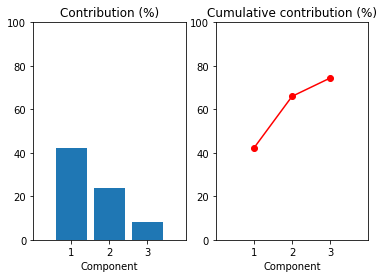

In [34]:
cum_pct = np.cumsum(pct)
x = np.arange(1,len(pct)+1,1)

plt.subplot(1, 2, 1)
plt.bar(x, pct * 100, align="center")
plt.title('Contribution (%)')
plt.xlabel('Component')
plt.xticks(x)
plt.xlim([0, 4])
plt.ylim([0, 100])

plt.subplot(1, 2, 2)
plt.plot(x, cum_pct * 100, 'ro-')
plt.title('Cumulative contribution (%)')
plt.xlabel('Component')
plt.xticks(x)
plt.xlim([0, 4])
plt.ylim([0, 100])

The chart on the left shows the contribution of the top three components toward the total variance. In other words, these components contribute the most to the information in the data. The first component explains 54.9% of the variation in the portfolio returns. In stock portfolios, this is usually driven by the overall market movement.

The chart on the right is the cumulative sum of the contribution of each component. It shows the top three components explain 84.7% of total portfolio returns. There’s no magic cumulative contribution but two or three components explaining close to 85% of the contribution is a good result.

So what does this actually mean?

# Isolate the alpha factors

There are forces that move stock prices that we can’t see. These latent factors are picked up through PCA and isolated as the principal components. The overall stock market is usually a strong driver of returns. Macroeconomic forces like interest rates and the pandemic drive returns, too. PCA lets you isolate these statistical factors to get an idea of how much the portfolio’s returns come from these unobserved features.

In [35]:
X = np.asarray(portfolio_returns)

factor_returns = X.dot(pca_components.T)

factor_returns = pd.DataFrame(
    columns=["f1", "f2", "f3"], 
    index=portfolio_returns.index,
    data=factor_returns
)

factor_returns.head()

,f1,f2,f3
Date,,,
2020-01-02,0.055983,-0.027631,0.001240
2020-01-03,-0.017971,0.000736,-0.040306
2020-01-06,0.022739,-0.004372,-0.004297
2020-01-07,0.025775,-0.017191,-0.030851
2020-01-08,0.021172,-0.100150,-0.024538


First, muliply the portfolio returns by the principle components. The dot function makes sure every return is multiplied by each of the components. the T function transposes the DataFrame. The resulting DataFrame gives you how much of that day’s portfolio return is a result of each of the three factors.

Similar stocks will be driven by similar factors. PCA makes it easy to visualize this.

<AxesSubplot:>

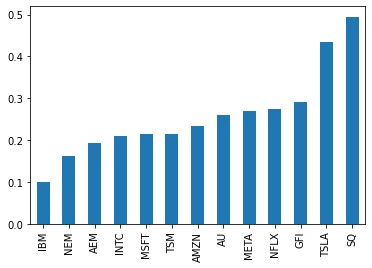

In [36]:
factor_exposures = pd.DataFrame(
    index=["f1", "f2", "f3"], 
    columns=portfolio_returns.columns,
    data = pca_components
).T

factor_exposures.f1.sort_values().plot.bar()

Analyze the first component. Create a DataFrame with the components, grab the first factor, sort stocks by the component, and plot them. You can see the tech stocks and the gold stocks clustered together. This component is more strongly driving the gold stocks. Can you guess what it is? (Hint: What major global event took place between January 2020 through November 2022?)

Another great way to visualize this is with a scatter plot.



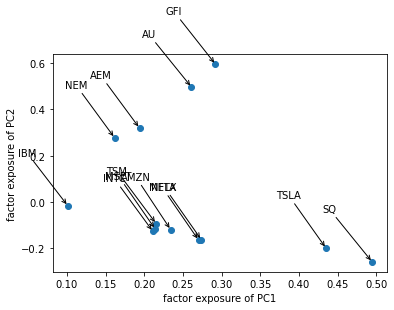

In [37]:
labels = factor_exposures.index
data = factor_exposures.values
plt.scatter(data[:, 0], data[:, 1])
plt.xlabel('factor exposure of PC1')
plt.ylabel('factor exposure of PC2')

for label, x, y in zip(labels, data[:, 0], data[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), 
        xytext=(-50, 50),
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

You can see how the stocks are driven by the first two principal components. Gold stocks were largely driven by factor one and tech stocks were negatively driven by factor two.

This analysis covered the time period during covid. Gold stocks were bid up strongly as a hedge against inflation and uncertainty. You might consider the first factor as a “covid factor” representing uncertainty across the market. Tech stocks crashed as worries of economic health began.

# Hedge Beta seek Alpha
Beta hedging concentrates exposure to alpha
Portfolio managers design factor models that tell them how to balance a portfolio to earn alpha. Because alpha is how managers get paid, they only want exposure to their factors. 
Beta hedging removes the part of returns driven by the market and leaves only the returns driven by the factors.

In [38]:
import numpy as np
from statsmodels import regression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import yfinance as yf

In [39]:
data = yf.download("TSLA, SPY", start="2014-01-01", end="2015-01-01")

asset = data["Adj Close"].TSLA
benchmark = data["Adj Close"].SPY

[*********************100%***********************]  2 of 2 completed


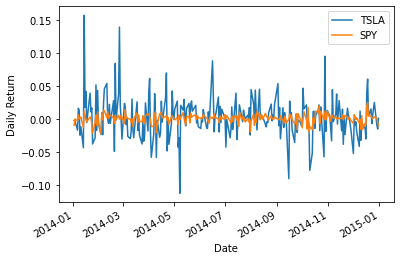

In [40]:
asset_returns = asset.pct_change().dropna()
benchmark_returns = benchmark.pct_change().dropna()

asset_returns.plot()
benchmark_returns.plot()
plt.ylabel("Daily Return")
plt.legend()

Find the portfolio’s alpha and beta

Linear regression models have an alpha term and one or more beta terms (plus an error). Alpha is the intercept and beta is the slope of the line that minimizes the error between all the points on a scatter plot. This will be clear when you see the chart.

In [41]:
X = benchmark_returns.values
Y = asset_returns.values

def linreg(x, y):
    # Add a column of 1s to fit alpha
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y, x).fit()
    # Remove the constant now that we're done
    x = x[:, 1]
    return model.params[0], model.params[1]

alpha, beta = linreg(X, Y)
print(f"Alpha: {alpha}")
print(f"Beta: {beta}")

Alpha: 0.000985722677041041
Beta: 1.9416257914010173


Linreg accepts two inputs: the independent variable (market returns) and the dependent variable (portfolio returns). Inside the function, add a column of 1s so statsmodels can find the alpha term. Then run the model and return the alpha and beta.

The alpha should be near 0. This means that by owning TSLA alone, you’re not beating the benchmark. The beta is 1.95. This means for every 1% the benchmark moves, TSLA moves 1.95% in the same direction.

Plot the returns and the regression line.

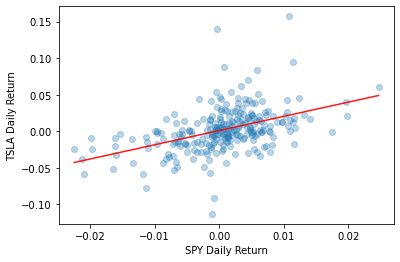

In [42]:
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha

# Plot the raw data
plt.scatter(X, Y, alpha=0.3)
plt.xlabel("SPY Daily Return")
plt.ylabel("TSLA Daily Return")

# Add the regression line
plt.plot(X2, Y_hat, 'r', alpha=0.9);

When SPY’s returns are 0, TSLA’s returns are near 0 too. That’s the intercept (alpha). The slope (beta) is measured by the change in TSLA divided by the change in SPY of the red line which is 1.95.

# Hedge beta

Because you’re only interested in exposure to the returns generated by owning TSLA, hedge the beta. Hedging beta will result in a portfolio with returns close to 0 because alpha is close to 0.

The first step is to construct a beta-hedged portfolio.

In [43]:
portfolio = -1 * beta * benchmark_returns + asset_returns
portfolio.name = "TSLA + Hedge"

beta hedged (market neutral) you should expect that the portfolio returns closely resemble that of TSLA.

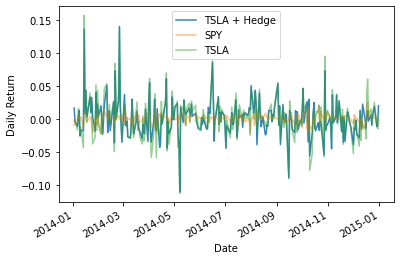

In [44]:
portfolio.plot(alpha=0.9)
benchmark_returns.plot(alpha=0.5);
asset_returns.plot(alpha=0.5);
plt.ylabel("Daily Return")
plt.legend();

In [51]:
# It looks like the portfolio return follows the asset. 
# Run the regression the the portfolio to make sure you removed the beta while keeping the alpha.

P = portfolio.values
alpha, beta = linreg(X, P)
print(f"Alpha: {alpha}")
print(f"Beta: {beta}")
if (beta < 0.001):
    print("The beta is 0. You’re hedged!")

Alpha: 0.00098572267704104
Beta: -5.065392549852277e-16
The beta is 0. You’re hedged!
